# Sommaire

* [Introduction](#introduction)
* [I) Importation des données](#i)
* [II) Nettoyage du jeu de données](#ii)
* [III) Régression linéaire](#iii)
* [IV) Préparation des données](#iv)
* [V) Régression logistique](#v)
* [VI) K-means](#vi)
* [VII) Un peu de visualisation](#vii)
* [VIII) Test](#viii)
* [Conclusion](#conclusion)

# Introduction <a class="anchor" id="introduction"></a>
L'ONCMF m'a chargé de mettre en place une modélisation qui serait capable d'identifier automatiquement les vrais des faux billets à partir de leurs dimensions.

Pour ce faire, j'ai commencé par un nettoyage des données qui a fait apparaître des valeurs manquantes. J'ai créé un modèle de régression linéaire pour les combler.

Ensuite j'ai créé deux modèles pour identifier les faux billets, une régression logistique et un k-means, afin de comparer leurs performances.

# I) Importation des données <a class="anchor" id="i"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import plotly.express as px
import datetime as dt
import scipy.stats as st
import math

In [2]:
billets = pd.read_csv('billets.csv', delimiter=';')
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


# II) Nettoyage du jeu de données <a class="anchor" id="ii"></a>

In [3]:
#Recherche erreurs de type
billets.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [4]:
#Recherche de valeurs manquantes
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [5]:
#Le collègue m'a dit qu'il avait eu un problème similaire, réglé à l'aide d'une régression linéaire
#On va poursuivre notre recherche d'erreurs et on y reviendra plus tard
#Recherche de doublons
billets.loc[billets.duplicated(keep=False)]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [6]:
#Recherche des outliers/valeurs aberrantes
billets.describe().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1463.00,1500.00,1500.00
mean,171.96,104.03,103.92,4.49,3.15,112.68
std,0.31,0.30,0.33,0.66,0.23,0.87
min,171.04,103.14,102.82,2.98,2.27,109.49
25%,171.75,103.82,103.71,4.01,2.99,112.03
50%,171.96,104.04,103.92,4.31,3.14,112.96
75%,172.17,104.23,104.15,4.87,3.31,113.34
max,173.01,104.88,104.95,6.90,3.91,114.44


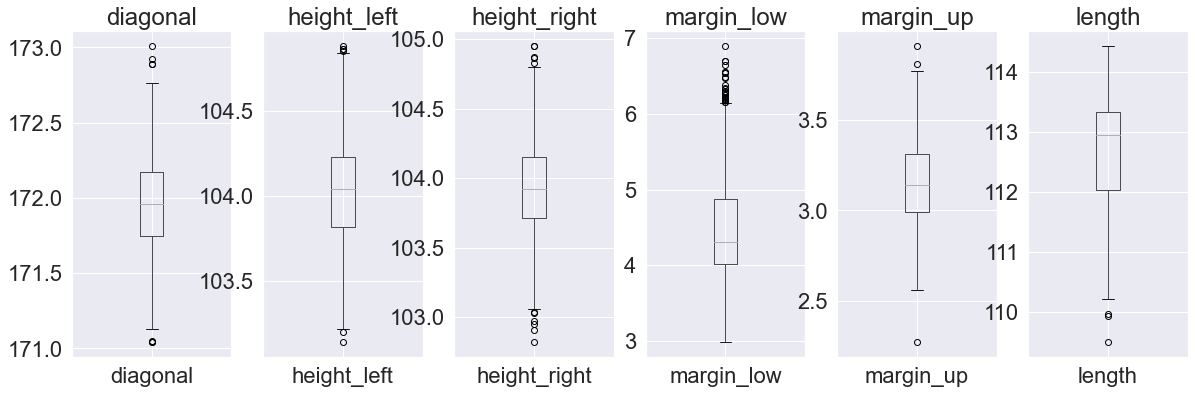

In [7]:
sns.set(font_scale=2)

fig, axes = plt.subplots(ncols=len(billets.iloc[:, 1:7].columns), figsize=(20, 6))

for i, col in enumerate(billets.iloc[:, 1:7].columns):
    billets[[col]].boxplot(ax=axes[i])
    axes[i].set_title(col)

plt.show()

In [8]:
#Quelques outliers, mais je n'élimine rien car ça aidera peut-être à distinguer les faux billets. Ex :
billets.sort_values('margin_low', ascending=False).head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1290,False,171.94,104.06,104.22,6.90,3.36,111.70
1027,False,171.63,104.02,104.66,6.70,3.28,111.28
1124,False,171.88,103.92,104.27,6.70,3.11,110.93
1041,False,171.77,104.12,104.42,6.65,3.63,111.53
1441,False,171.63,104.55,103.81,6.56,3.10,111.87
1110,False,171.73,104.32,104.07,6.56,3.30,112.80
1464,False,172.07,104.17,104.37,6.54,3.54,111.20
1254,False,171.15,104.09,104.30,6.49,3.20,111.61
1169,False,171.99,104.14,104.15,6.48,3.42,112.16
1420,False,171.56,104.47,104.04,6.38,3.43,112.12


# III) Régression linéaire <a class="anchor" id="iii"></a>

In [9]:
#On revient à nos valeurs manquantes, on sépare en 2 dataframes, un avec uniquement nos valeurs manquantes et un sans
#On va drop la colonne 'is_genuine'
billets_drop = billets.drop('is_genuine', axis=1)
billets_drop

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28
1496,172.19,104.63,104.44,5.27,3.37,110.97
1497,171.80,104.01,104.12,5.51,3.36,111.95
1498,172.06,104.28,104.06,5.17,3.46,112.25


In [10]:
#Valeurs à prédire
pred_billets = billets_drop[billets_drop['margin_low'].isnull()]
pred_billets.head(5)

,diagonal,height_left,height_right,margin_low,margin_up,length
72,171.94,103.89,103.45,NaN,3.25,112.79
99,171.93,104.07,104.18,NaN,3.14,113.08
151,172.07,103.80,104.38,NaN,3.02,112.93
197,171.45,103.66,103.80,NaN,3.62,113.27
241,171.83,104.14,104.06,NaN,3.02,112.36


In [11]:
#tt pour train et test
tt_billets = billets_drop.dropna(inplace=False)
tt_billets

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28
1496,172.19,104.63,104.44,5.27,3.37,110.97
1497,171.80,104.01,104.12,5.51,3.36,111.95
1498,172.06,104.28,104.06,5.17,3.46,112.25


In [12]:
#On créé X et y
X = tt_billets.drop('margin_low', axis=1)
X

,diagonal,height_left,height_right,margin_up,length
0,171.81,104.86,104.95,2.89,112.83
1,171.46,103.36,103.66,2.99,113.09
2,172.69,104.48,103.50,2.94,113.16
3,171.36,103.91,103.94,3.01,113.51
4,171.73,104.28,103.46,3.48,112.54
...,...,...,...,...,...
1495,171.75,104.38,104.17,3.09,111.28
1496,172.19,104.63,104.44,3.37,110.97
1497,171.80,104.01,104.12,3.36,111.95
1498,172.06,104.28,104.06,3.46,112.25


In [13]:
y = tt_billets['margin_low']
y

0       4.52
1       3.77
2       4.40
3       3.62
4       4.04
        ... 
1495    4.42
1496    5.27
1497    5.51
1498    5.17
1499    4.63
Name: margin_low, Length: 1463, dtype: float64

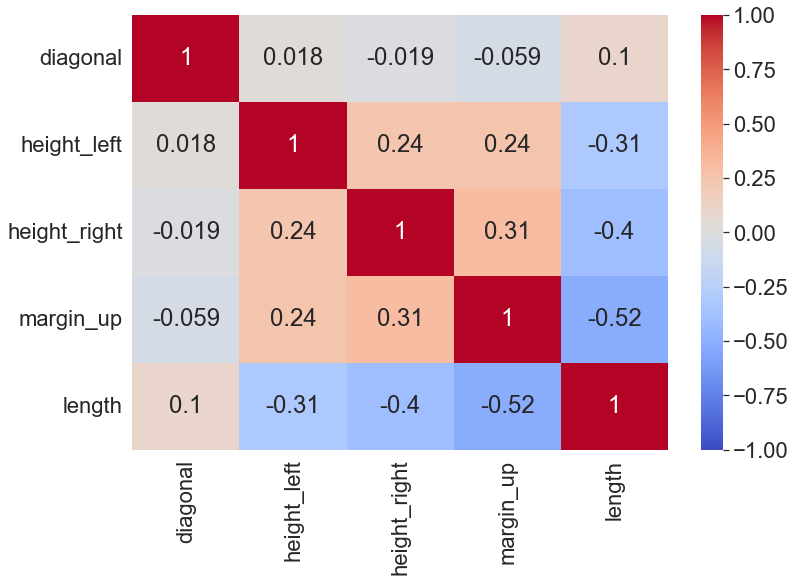

In [14]:
#On commence par se poser la question de la colinéarité des variables
corr_matrix = X.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1)
plt.show()

In [15]:
#En dehors de length et margin_up, le reste des variables ne semblent que moyennement corrélées une à une
#On calcule le facteur d'inflation de la variance
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

print(vif)

diagonal        170566.670778
height_left     111895.309916
height_right    100858.864433
margin_up          261.969190
length           22708.222743
dtype: float64


In [16]:
#On note des VIF très élevés, cela indique que les corrélations entre chaque variable et les reste des variables sont élevées
#On va créer un premier modèle avec toutes les variables pour commencer, on expérimentera après
#Plutôt que d'utiliser toutes les données pour modéliser, nous allons les séparer en training set et testing set
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

In [17]:
#On fit le modèle de régression linéaire
from sklearn.linear_model import LinearRegression

linre = LinearRegression()
linre.fit(xtrain, ytrain)

LinearRegression()

In [18]:
#On applique le modèle sur xtest, et on arrondit à 2 décimales
ypred = linre.predict(xtest)
ypred = np.round(ypred, 2)
ypred

array([4.06, 4.17, 5.33, 4.22, 4.16, 4.34, 4.36, 5.13, 4.22, 4.2 , 5.03,
       4.95, 4.16, 4.33, 4.72, 5.2 , 4.01, 4.13, 4.15, 5.1 , 5.19, 4.38,
       4.03, 4.1 , 4.29, 4.41, 3.92, 4.98, 4.95, 4.23, 4.43, 4.07, 5.08,
       4.05, 4.23, 4.31, 5.39, 4.6 , 4.54, 4.07, 4.93, 5.23, 4.21, 4.13,
       4.24, 3.82, 4.7 , 4.63, 4.02, 4.42, 5.14, 4.03, 4.34, 5.13, 4.19,
       4.05, 4.3 , 3.93, 4.27, 4.26, 5.09, 3.94, 5.32, 4.  , 4.34, 5.09,
       4.09, 4.35, 4.39, 4.17, 4.34, 4.37, 4.3 , 4.83, 4.67, 3.81, 4.22,
       4.36, 4.55, 5.19, 3.84, 4.62, 3.97, 3.96, 3.98, 4.36, 5.35, 4.52,
       5.05, 4.94, 4.52, 4.34, 4.08, 5.07, 5.29, 4.33, 4.3 , 4.95, 4.47,
       4.96, 4.21, 4.39, 4.97, 4.46, 4.49, 5.38, 4.95, 4.24, 4.15, 4.36,
       4.13, 4.63, 4.77, 4.27, 5.27, 4.96, 4.4 , 5.04, 5.13, 4.75, 5.16,
       4.12, 3.94, 4.95, 4.18, 4.67, 4.5 , 4.15, 3.79, 4.79, 4.24, 4.74,
       3.86, 3.85, 4.21, 3.86, 4.5 , 4.3 , 4.21, 4.56, 4.25, 5.24, 4.21,
       4.24, 4.36, 4.15, 4.95, 4.88, 4.33, 5.22, 5.

In [19]:
#On va mesurer le coefficient de détermination R², la proportion de la variance de margin_low expliquée par les autres variables
#On mesure également l'erreur quadratique moyenne (RMSE)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

r2 = round(r2_score(ytest, ypred), 2)
rmse = round(mean_squared_error(ytest, ypred, squared=False), 2)

print("R² :", r2)
print("RMSE :", rmse)

R² : 0.49
RMSE : 0.48


In [20]:
#On va s'intéresser un peu aux résidus
#Le test de Kolmogorov-Smirnov teste l'hypothèse H0 selon laquelle les résidus suivent une distribution de loi normale
st.kstest(ytest - ypred, 'norm')

KstestResult(statistic=0.20592296980465935, pvalue=2.255382613974014e-11)

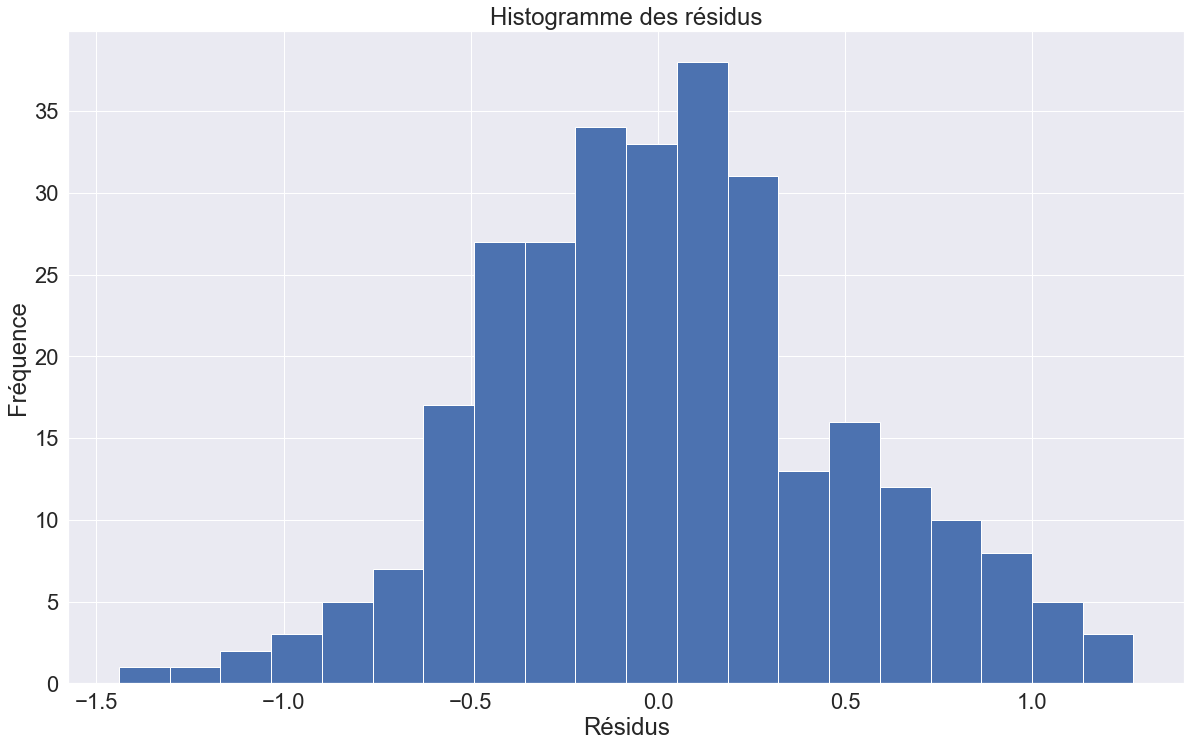

In [21]:
#La p-value étant quasi nulle, on rejète H0
#Pour visualiser

résidus = ytest - ypred

#Histogramme des résidus
plt.figure(figsize=(20,12))
plt.hist(résidus, bins=20)
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Histogramme des résidus')
plt.show()

In [22]:
#On test maintenant l'homoscédasticité des résidus, la distribution étant non normale on utilise le test de Levene
#On test l'hypothèse H0 selon laquelle la variance des erreurs de la régression est la même pour chaque observation
st.levene(ytest, ypred)

LeveneResult(statistic=26.307996888315724, pvalue=3.966197123699671e-07)

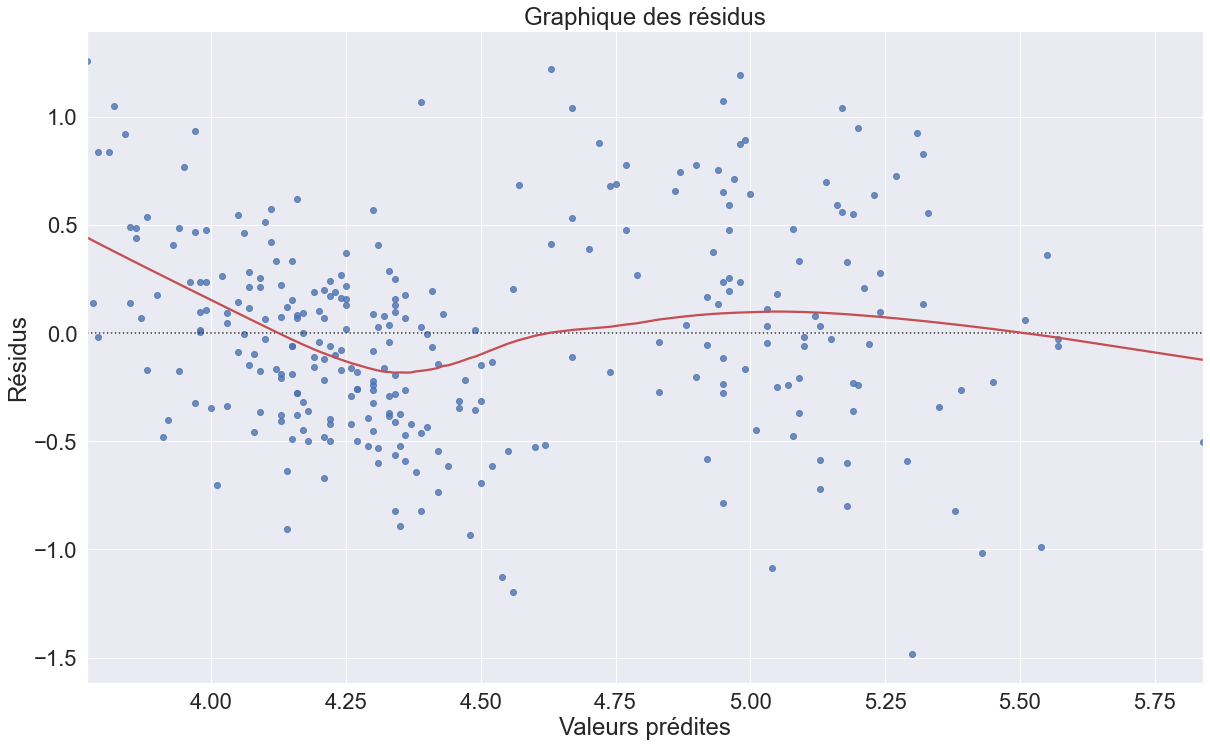

In [23]:
#La p-value étant quasi nulle, on en déduit que les variances des résidus sont différentes, il y hétéroscédasticité
#Pour visualiser

#Graphique des résidus
plt.figure(figsize=(20,12))
sns.residplot(x=ypred, y=résidus, lowess=True, line_kws=dict(color="r"))
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphique des résidus")
plt.show()

In [24]:
#Par curiosité je vais essayer d'améliorer le modèle
#La variable avec le VIF le plus élevé étant diagonal, je vais essayer de relancer l'algorithme en ignorant cette variable
X2 = X.drop(['diagonal'], axis=1)
X2

,height_left,height_right,margin_up,length
0,104.86,104.95,2.89,112.83
1,103.36,103.66,2.99,113.09
2,104.48,103.50,2.94,113.16
3,103.91,103.94,3.01,113.51
4,104.28,103.46,3.48,112.54
...,...,...,...,...
1495,104.38,104.17,3.09,111.28
1496,104.63,104.44,3.37,110.97
1497,104.01,104.12,3.36,111.95
1498,104.28,104.06,3.46,112.25


In [25]:
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(X2, y, train_size=0.8)
linre.fit(xtrain2, ytrain2)

LinearRegression()

In [26]:
ypred2 = linre.predict(xtest2)
ypred2 = np.round(ypred2, 2)
ypred2

array([5.27, 4.25, 4.31, 4.05, 4.29, 4.08, 4.64, 4.29, 4.52, 5.09, 4.61,
       4.68, 4.9 , 4.03, 4.25, 4.24, 4.14, 4.15, 4.54, 5.12, 4.39, 4.22,
       5.23, 4.12, 5.15, 4.83, 4.23, 5.27, 4.45, 4.18, 4.35, 4.05, 4.28,
       4.09, 3.91, 4.25, 4.1 , 4.36, 4.26, 4.21, 4.28, 3.99, 4.47, 4.33,
       5.16, 4.4 , 5.25, 4.06, 5.11, 4.95, 4.15, 4.12, 4.11, 4.75, 4.35,
       5.05, 4.13, 4.29, 5.05, 5.12, 4.82, 5.06, 4.13, 4.94, 5.05, 4.  ,
       4.04, 4.05, 4.18, 3.95, 4.17, 4.85, 4.11, 5.14, 4.05, 4.62, 4.44,
       4.14, 4.09, 4.71, 4.23, 5.08, 4.2 , 4.93, 3.99, 4.12, 5.47, 3.97,
       4.08, 4.26, 4.26, 4.06, 4.35, 4.21, 4.55, 3.99, 4.18, 4.37, 4.14,
       4.09, 4.76, 4.22, 4.17, 5.23, 5.23, 4.88, 4.08, 4.21, 4.91, 4.93,
       4.08, 3.96, 4.92, 4.31, 4.15, 4.15, 5.23, 4.34, 4.21, 4.55, 4.53,
       4.88, 4.27, 5.05, 4.24, 5.11, 4.18, 4.48, 4.26, 4.  , 4.94, 3.94,
       4.53, 4.58, 5.3 , 4.36, 5.04, 4.52, 4.33, 5.47, 5.41, 4.08, 4.94,
       4.36, 3.76, 4.28, 3.9 , 4.41, 4.15, 4.3 , 4.

In [27]:
#Une nouvelle fois, on mesure R² et RMSE
r22 = round(r2_score(ytest2, ypred2), 2)
rmse2 = round(mean_squared_error(ytest2, ypred2, squared=False), 2)

print("R² :", r22)
print("RMSE :", rmse2)

R² : 0.46
RMSE : 0.49


In [28]:
#Peu de changement niveau R² et RMSE
#On relance le test de Kolmogorov-Smirnov, même H0
st.kstest(ytest2 - ypred2, 'norm')

KstestResult(statistic=0.19282691402733254, pvalue=5.121225107183452e-10)

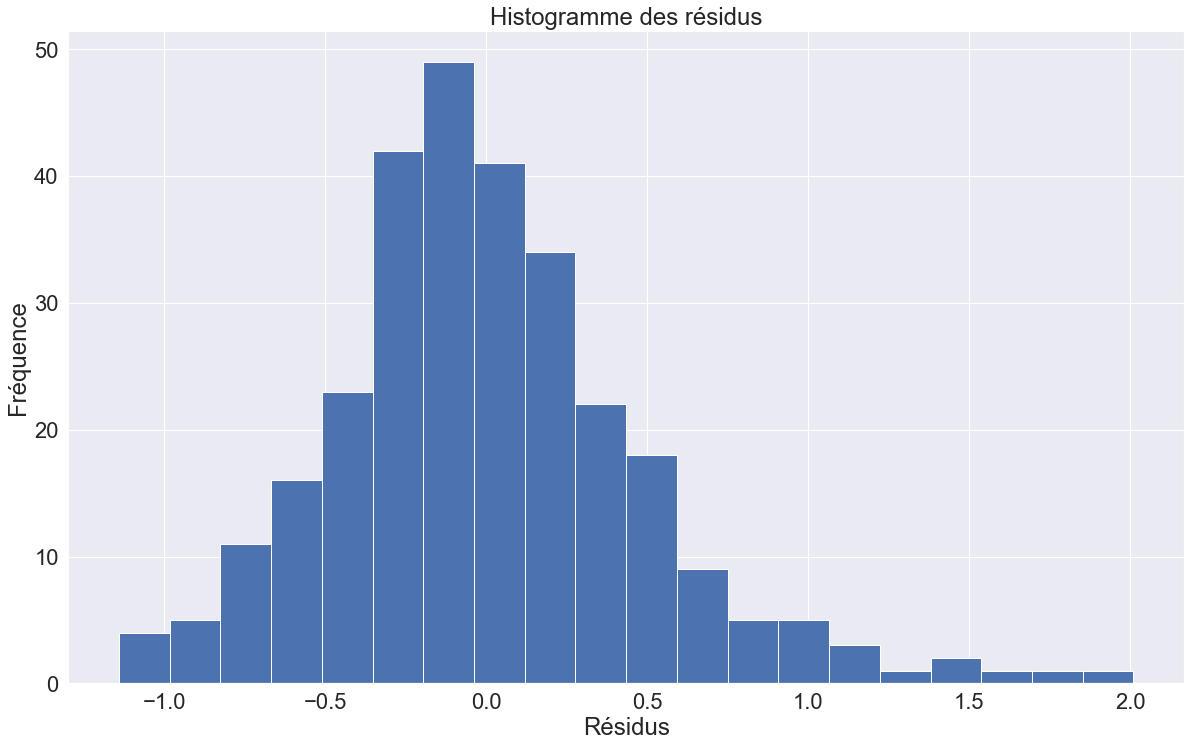

In [29]:
#La p-value étant quasi nulle une nouvelle fois, on rejète H0
#Pour visualiser

résidus2 = ytest2 - ypred2

#Histogramme des résidus
plt.figure(figsize=(20,12))
plt.hist(résidus2, bins=20)
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Histogramme des résidus')
plt.show()

In [30]:
#On retest l'homoscédasticité, même H0
st.levene(ytest2, ypred2)

LeveneResult(statistic=25.306468331789926, pvalue=6.518819387766614e-07)

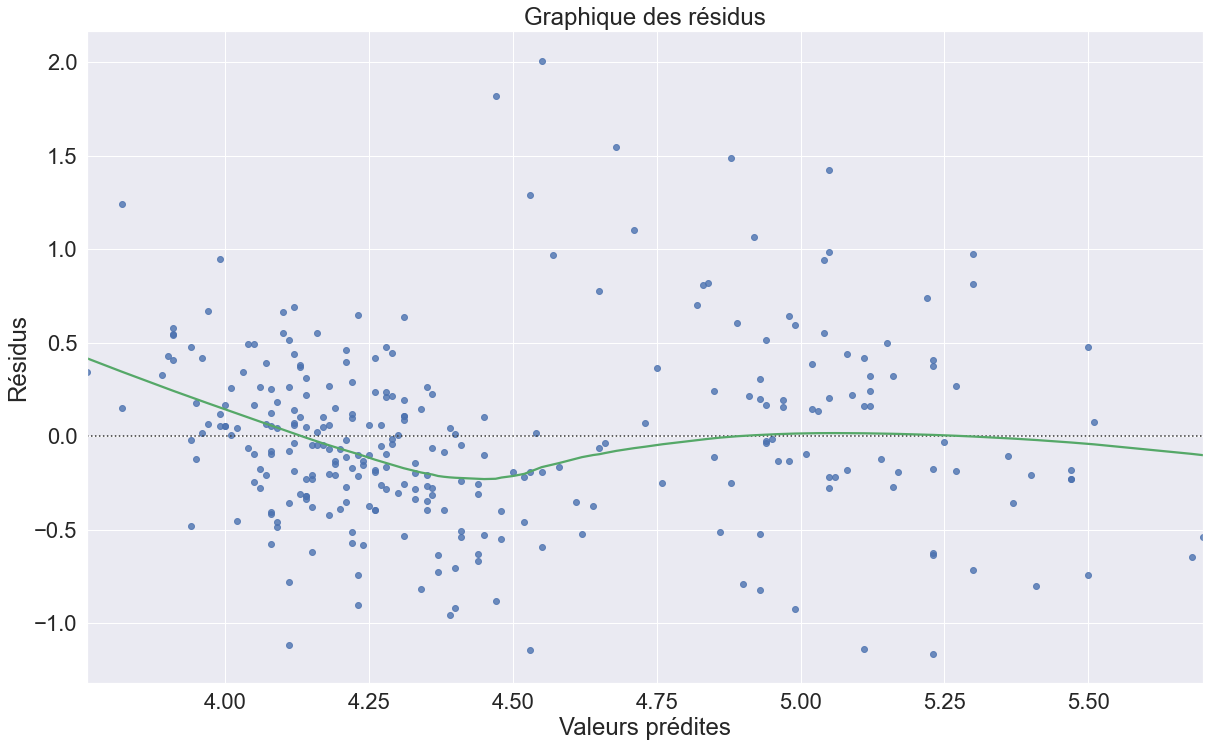

In [31]:
#La p-value étant quasi nulle, on en déduit que les variances des résidus sont différentes, il y hétéroscédasticité
#Pour visualiser

#Graphique des résidus
plt.figure(figsize=(20,12))
sns.residplot(x=ypred2, y=résidus2, lowess=True, line_kws=dict(color="g"))
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphique des résidus")
plt.show()

In [32]:
#On fait le même constat que tout à l'heure
#En fait j'ai fait une dizaine de tests, en ignorant chaque variable, parfois plusieurs, mais cela n'améliore pas les résultats
#La différence entre les deux modèles étant minime, je décide de garder celui-ci
X3 = pred_billets.drop(['diagonal', 'margin_low'], axis=1)
X3.head(5)

,height_left,height_right,margin_up,length
72,103.89,103.45,3.25,112.79
99,104.07,104.18,3.14,113.08
151,103.80,104.38,3.02,112.93
197,103.66,103.80,3.62,113.27
241,104.14,104.06,3.02,112.36


In [33]:
ypred3 = linre.predict(X3)
ypred3 = np.round(ypred3, 2)
ypred3

array([4.31, 4.39, 4.44, 4.26, 4.64, 3.8 , 4.18, 4.13, 4.21, 4.2 , 4.19,
       3.78, 4.07, 4.28, 4.18, 4.07, 4.45, 4.49, 4.36, 4.13, 3.61, 4.34,
       4.1 , 4.18, 3.89, 3.75, 4.26, 4.69, 4.13, 5.01, 4.73, 5.04, 5.06,
       4.79, 5.69, 5.26, 5.14])

In [34]:
#On remplace les valeurs manquantes
billets.loc[billets['margin_low'].isnull(), 'margin_low'] = ypred3

In [35]:
#On vérifie, super nickel
billets.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

# IV) Préparation des données <a class="anchor" id="iv"></a>

In [36]:
#On (re)définit X et y
X = billets.iloc[:,1:]
X

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28
1496,172.19,104.63,104.44,5.27,3.37,110.97
1497,171.80,104.01,104.12,5.51,3.36,111.95
1498,172.06,104.28,104.06,5.17,3.46,112.25


In [37]:
y = billets.iloc[:,0]
y

0        True
1        True
2        True
3        True
4        True
        ...  
1495    False
1496    False
1497    False
1498    False
1499    False
Name: is_genuine, Length: 1500, dtype: bool

In [38]:
#Comme tout à l'heure, training set et testing set
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

In [39]:
#On va scale nos données
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtrain_scaled

array([[-0.57880292,  0.50843919,  1.85312505,  1.03295294,  1.56300365,
        -0.32658801],
       [-0.05504875, -1.2621753 , -0.08763756, -0.75136662,  0.21085519,
        -0.00304287],
       [ 1.38527524,  0.17436098, -0.51217938, -0.95307231, -0.87958711,
         0.63249224],
       ...,
       [ 3.02200704, -0.86128145,  0.94339257, -0.53414511, -0.61788096,
         1.19869624],
       [ 0.30503225, -0.09290158,  0.27625543,  0.97088965,  1.65023903,
        -0.70790907],
       [ 0.66511325, -1.39580658,  1.21631232, -1.66680013, -1.44661711,
         0.12406416]])

In [40]:
xtest_scaled = scaler.transform(xtest)
xtest_scaled

array([[-0.21872193,  0.74229393,  2.15636921, -0.00660715, -0.3561748 ,
        -2.1060863 ],
       [-1.39716882,  0.80910957,  0.24593101,  0.25716182, -0.44341019,
         0.47071967],
       [-0.05504875, -2.26440992, -0.51217938, -0.95307231,  0.60341442,
         0.4476093 ],
       ...,
       [-0.31692583,  2.44609278,  0.27625543,  2.84830414,  1.99918057,
        -1.6092134 ],
       [ 0.59964397,  0.34140009, -1.23996536, -0.72033498, -0.26893942,
         0.28583673],
       [ 0.14135907,  0.10754534,  0.57949959,  1.93287063,  0.86512057,
        -1.93275854]])

In [41]:
#On récupère nos colonnes pour plus tard
éléments = X.columns
éléments

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

# V) Régression logistique <a class="anchor" id="v"></a>

In [42]:
#On fit le modèle de régression logistique
#La pénalité par défaut est L2 (ou ridge) et permet généralement d'éviter l'overfitting
from sklearn.linear_model import LogisticRegression
logre = LogisticRegression()
logre.fit(xtrain_scaled,ytrain)

LogisticRegression()

In [43]:
ypred = logre.predict(xtest_scaled)
ypred

array([False,  True,  True,  True, False,  True,  True, False,  True,
       False,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False, False,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True, False,  True, False,  True,
        True,  True, False,  True,  True, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True, False,  True,  True, False,
       False, False,  True,  True,  True, False, False,  True,  True,
       False,  True,  True, False,  True,  True,  True, False,  True,
        True,  True, False,  True, False, False, False, False, False,
        True, False,  True,  True,  True,  True, False,  True, False,
        True, False,  True,  True,  True,  True, False, False,  True,
        True, False,  True,  True, False,  True,  True, False,  True,
       False,  True,

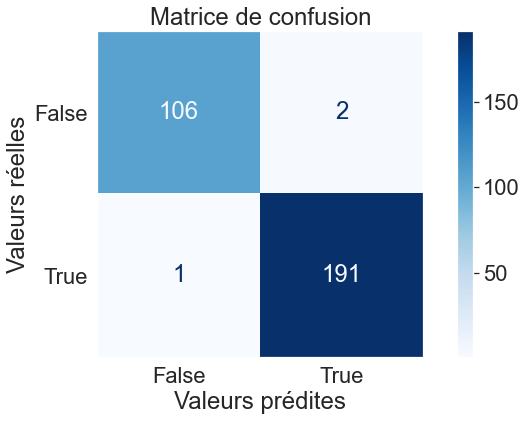

In [44]:
#On plot une matrice de confusion pour comparer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(ytest, ypred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['False', 'True'])
cmd.plot(cmap=plt.cm.Blues)
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de confusion")
plt.gcf().set_size_inches(12,6)
plt.grid(False)
plt.show()

In [45]:
#Très peu d'erreurs, le modèle semble vraiment performant
#On va quand même effectuer quelques tests
from sklearn.metrics import classification_report

report = classification_report(ytest, ypred)

print(report)

#Accuracy = Combien de valeurs ont été correctement prédites
#Precision = Parmi les billets prédits vrais, combien le sont réellement
#Recall = Parmi les vrais billets, combien ont été correctement prédits
#F1 = Combinaison de precision et recall

              precision    recall  f1-score   support

       False       0.99      0.98      0.99       108
        True       0.99      0.99      0.99       192

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



# VI) K-means <a class="anchor" id="vi"></a>

In [46]:
#On va tester plusieurs valeurs de k pour voir laquelle est la plus adaptée, et noter l'inertie intraclasse obtenue
#Liste vide pour enregistrer les inerties
liste_inertie = []

In [47]:
#Nombre de clusters, je prévois large
k_list = range(1,10)

In [48]:
#On instancie
#On note que k-means est un algorithme non supervisé et n'a pas besoin d'ytrain d'où le kmeans.fit(xtrain_scaled) seulement
from sklearn.cluster import KMeans

for k in k_list :
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(xtrain_scaled)
    liste_inertie.append(kmeans.inertia_)

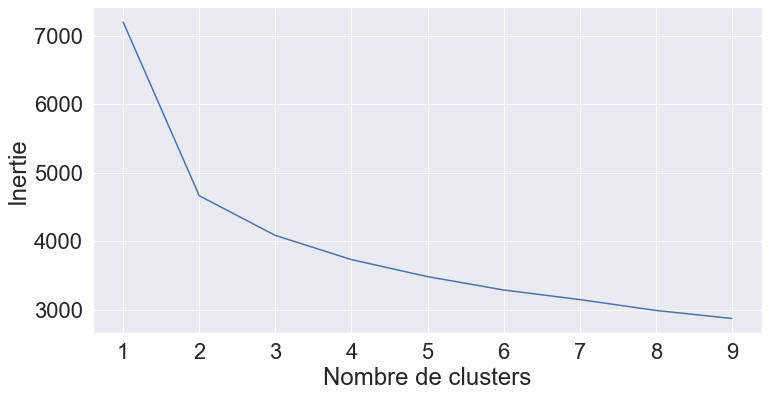

In [49]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("Inertie")
ax.set_xlabel("Nombre de clusters")

ax = plt.plot(k_list, liste_inertie)

In [50]:
#Selon ce graphique, en appliquant la méthode du coude, il semblerait que 2 clusters soient plus adapté
#Sans surprise puisqu'on s'attend à avoir des True et des False
kmeans = KMeans(n_clusters=2)
kmeans.fit(xtrain_scaled)

KMeans(n_clusters=2)

In [51]:
ypred2 = kmeans.predict(xtest_scaled)
ypred2

array([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0])

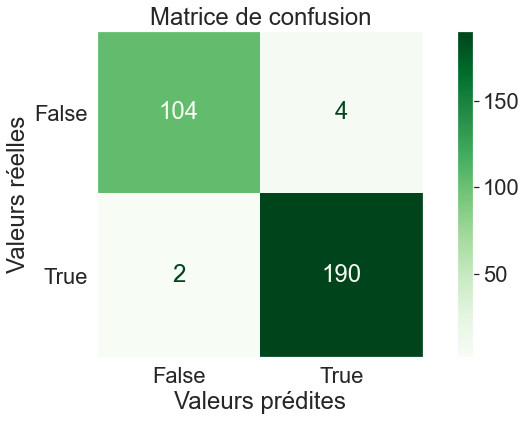

In [52]:
#On plot une matrice de confusion pour comparer

cm2 = confusion_matrix(ytest, ypred2)
cmd2 = ConfusionMatrixDisplay(cm2, display_labels=['False', 'True'])
cmd2.plot(cmap=plt.cm.Greens)
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de confusion")
plt.gcf().set_size_inches(12,6)
plt.grid(False)
plt.show()

In [53]:
#Encore une fois, on obtient de très bons résultats
report = classification_report(ytest, ypred2)

print(report)

              precision    recall  f1-score   support

       False       0.98      0.96      0.97       108
        True       0.98      0.99      0.98       192

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [54]:
#On obtient les clusters d'xtrain
clusters = kmeans.labels_
clusters

array([0, 1, 1, ..., 1, 0, 1])

In [55]:
#On enregistre les centroïdes
centroids = kmeans.cluster_centers_
centroids

array([[-0.16648046,  0.57149538,  0.71157754,  1.1284685 ,  0.87571822,
        -1.21415024],
       [ 0.08046213, -0.27621099, -0.34391448, -0.54540319, -0.42324577,
         0.58681427]])

In [56]:
#C'est nécessaire pour plus tard
centroids = scaler.inverse_transform(centroids)

In [57]:
centroids = pd.DataFrame(centroids)
centroids.columns = éléments
centroids['clusters'] = [0, 1]
centroids

,diagonal,height_left,height_right,margin_low,margin_up,length,clusters
0,171.915959,104.198875,104.163555,5.191560,3.352430,111.631893,0
1,171.991397,103.945130,103.815488,4.112744,3.054623,113.190470,1


In [58]:
#On affiche une colonne clusters pour xtrain et xtest
xtrain['clusters'] = clusters
xtrain

,diagonal,height_left,height_right,margin_low,margin_up,length,clusters
1491,171.79,104.18,104.54,5.13,3.51,112.40,0
898,171.95,103.65,103.90,3.98,3.20,112.68,1
928,172.39,104.08,103.76,3.85,2.95,113.23,1
139,172.46,103.81,103.52,4.05,3.16,112.60,1
919,171.92,103.68,103.45,3.75,2.58,113.68,1
...,...,...,...,...,...,...,...
50,171.95,104.02,103.82,4.28,3.00,113.28,1
1445,172.14,104.39,104.10,4.44,3.34,111.86,0
842,172.89,103.77,104.24,4.12,3.01,113.72,1
1288,172.06,104.00,104.02,5.09,3.53,112.07,0


In [59]:
xtest['clusters'] = ypred2
xtest

,diagonal,height_left,height_right,margin_low,margin_up,length,clusters
1143,171.90,104.25,104.64,4.46,3.07,110.86,0
300,171.54,104.27,104.01,4.63,3.05,113.09,1
612,171.95,103.35,103.76,3.85,3.29,113.07,1
419,171.56,103.97,103.96,4.12,3.32,113.43,1
1380,171.58,103.87,104.07,4.67,3.51,111.53,0
...,...,...,...,...,...,...,...
892,172.63,104.13,104.17,3.77,3.45,113.34,1
591,171.67,103.81,103.76,4.59,3.30,112.18,1
1092,171.87,104.76,104.02,6.30,3.61,111.29,0
818,172.15,104.13,103.52,4.00,3.09,112.93,1


In [60]:
X_clusters = pd.concat([xtrain, xtest]).sort_index()
X_clusters

,diagonal,height_left,height_right,margin_low,margin_up,length,clusters
0,171.81,104.86,104.95,4.52,2.89,112.83,0
1,171.46,103.36,103.66,3.77,2.99,113.09,1
2,172.69,104.48,103.50,4.40,2.94,113.16,1
3,171.36,103.91,103.94,3.62,3.01,113.51,1
4,171.73,104.28,103.46,4.04,3.48,112.54,1
...,...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28,0
1496,172.19,104.63,104.44,5.27,3.37,110.97,0
1497,171.80,104.01,104.12,5.51,3.36,111.95,0
1498,172.06,104.28,104.06,5.17,3.46,112.25,0


In [61]:
X_concat = pd.concat([X_clusters, centroids])
X_concat

,diagonal,height_left,height_right,margin_low,margin_up,length,clusters
0,171.810000,104.860000,104.950000,4.520000,2.890000,112.830000,0
1,171.460000,103.360000,103.660000,3.770000,2.990000,113.090000,1
2,172.690000,104.480000,103.500000,4.400000,2.940000,113.160000,1
3,171.360000,103.910000,103.940000,3.620000,3.010000,113.510000,1
4,171.730000,104.280000,103.460000,4.040000,3.480000,112.540000,1
...,...,...,...,...,...,...,...
1497,171.800000,104.010000,104.120000,5.510000,3.360000,111.950000,0
1498,172.060000,104.280000,104.060000,5.170000,3.460000,112.250000,0
1499,171.470000,104.150000,103.820000,4.630000,3.370000,112.070000,0
0,171.915959,104.198875,104.163555,5.191560,3.352430,111.631893,0


# VII) Un peu de visualisation <a class="anchor" id="vii"></a>

In [62]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto', init='random')

X_tsne = tsne.fit_transform(X_concat.iloc[:,:-1])

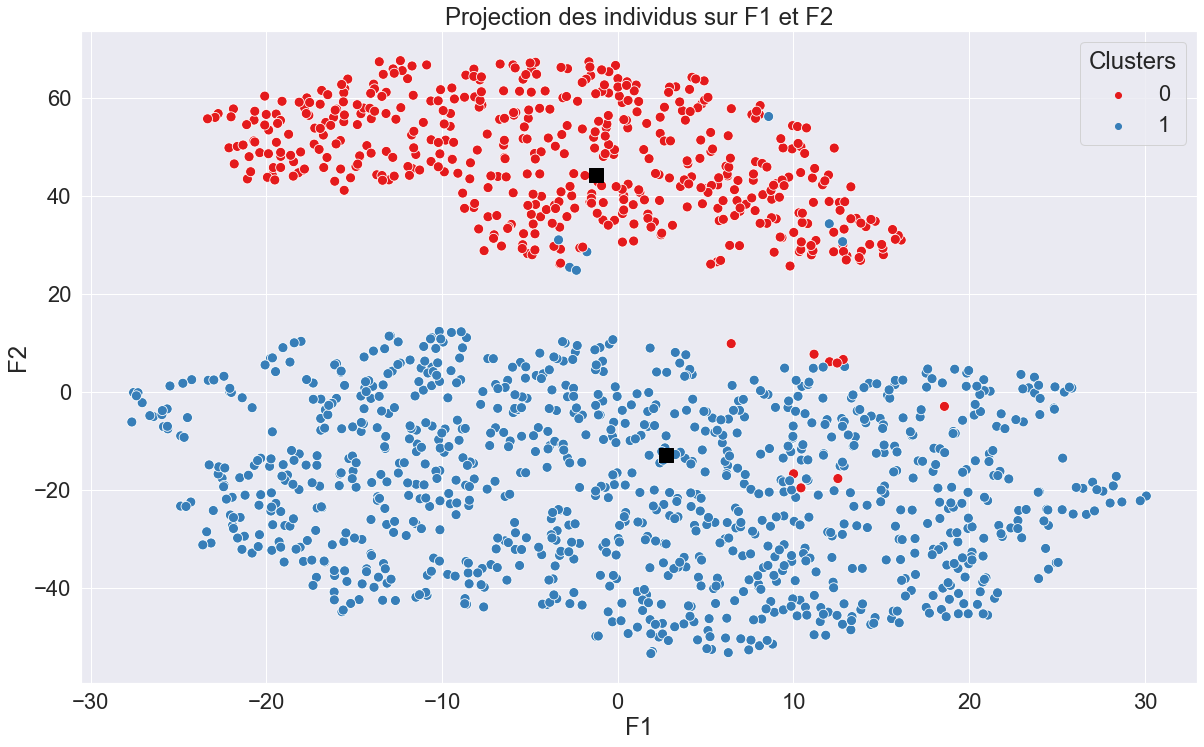

In [63]:
plt.figure(figsize=(20,12))
sns.scatterplot(data=X_tsne, x=X_tsne[:, 0], y=X_tsne[:, 1], hue=X_concat['clusters'], palette='Set1', s=100)
plt.scatter(x=X_tsne[-2:, 0], y=X_tsne[-2:, 1], c='black', marker='s', s=200) #Centroïdes
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Projection des individus sur F1 et F2')
plt.legend(title='Clusters')
plt.show()

# VIII) Test <a class="anchor" id="viii"></a>

In [64]:
production =  pd.read_csv('billets_production.csv')
production

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [65]:
production_scaled = scaler.transform(production.iloc[:,:-1])
production_scaled

array([[-0.67700683, -0.05949376, -1.17931653,  1.15707951,  0.64703211,
        -1.45899601],
       [-0.31692583,  0.47503137,  0.609824  ,  2.38282947,  0.69064981,
        -0.6847987 ],
       [ 0.10862443,  1.84475201,  1.09501465,  0.81573142,  1.03959134,
        -1.28566826],
       [ 1.7126216 ,  1.74452855,  1.24663673, -0.0376388 , -0.53064557,
         0.59782669],
       [-1.03708783, -1.32899094, -1.1186677 , -1.07719889,  0.03638442,
         0.74804408]])

In [66]:
production_pred = logre.predict(production_scaled)
production_pred

array([False, False, False,  True,  True])

In [67]:
production['is_genuine'] = production_pred
production

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True


# Conclusion <a class="anchor" id="conclusion"></a>
Au regard des indicateurs, les deux modèles créés sont performant, mais la régression logistique semble légèrement plus fiable, donc je suggère de privilégier celle-ci à l'avenir.

In [70]:
soutenance = pd.read_csv('soutenance.csv')
soutenance

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [71]:
soutenance_scaled = scaler.transform(soutenance.iloc[:,:-1])
soutenance_scaled

array([[ 0.40323616, -0.25994068, -0.60315263, -0.11521791, -0.26893942,
         0.5862715 ],
       [-1.4626381 ,  0.47503137,  0.30657984,  1.25017445,  0.03638442,
        -0.99678866],
       [-0.61153756, -0.76105799, -0.5425038 , -1.0151356 ,  0.38532596,
         0.81737518],
       [ 0.17409371,  0.17436098,  0.18528218,  1.71564912,  0.64703211,
        -1.82876189],
       [-0.57880292,  1.04296432,  1.33760998,  0.83124725, -0.3561748 ,
        -0.93901275]])

In [72]:
soutenance_pred = logre.predict(soutenance_scaled)
soutenance_pred

array([ True, False,  True, False, False])

In [73]:
soutenance['is_genuine'] = soutenance_pred
soutenance

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,True
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,False
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,True
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,False
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,False
